ASL, 27.02.23

# Introduction

In this notebook, we'll do a quick exploration of the [PlantDoc data set](https://github.com/pratikkayal/PlantDoc-Dataset). We'll look at the distribution of the data and labels. Then we'll train a model to see how well we can predict the labels.

<img src="assets/plantdoc.png">

It was introduced by Singh et al. in [this paper](https://arxiv.org/abs/1911.10317) (from where the above figure is taken).

# Setup

We'll use the standard fastai setup for vision application (with which you're very familiar by now).

In [ ]:
import timm
from fastai.imports import *
from fastai.basics import untar_data

In [ ]:
# This will probably be repeated across many notebooks
# Best to put it in a file under "../src/data" and import from there

NB_DIR = Path.cwd()
DATA = NB_DIR/'..'/'data'
RAW = DATA/'raw'
INTERIM = DATA/'interim'
PROCESSED = DATA/'processed'

# Download data

The data is available on [GitHub](https://github.com/pratikkayal/PlantDoc-Dataset)

In [ ]:
url = "https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip"

In [ ]:
#path = untar_data(url)

To save time, I've downloaded the data before the lecture.

In [ ]:
path = Path.home()/'data'/'PlantDoc'/'PlantDoc-Dataset-master'

In [ ]:
path.ls()

# Inspect data

What is the distribution of the labels?

In [ ]:
train_path = path/'train'
test_path = path/'test'

In [ ]:
train_classes = {}
test_classes = {}
for p in train_path.iterdir():
    train_classes[p.stem] = len(p.ls())
for p in test_path.iterdir():
    test_classes[p.stem] = len(p.ls())

In [ ]:
plt.bar(train_classes.keys(), train_classes.values())
plt.bar(test_classes.keys(), test_classes.values())
plt.xticks(rotation=90)
plt.show()

## Create dataloaders

In [ ]:
from fastai.vision.all import *

## Data augmentation

In [ ]:
batch_tfms = [Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), Saturation(),
            Zoom(), RandomErasing(), Normalize.from_stats(*imagenet_stats)]

## Dataloaders

In [ ]:
bs=4 # set a batch size that fits in your GPU memory

dls = ImageDataLoaders.from_folder(train_path, bs=bs, valid_pct=0.2, 
                        item_tfms=Resize(800),
                        batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])       
                            

In [ ]:
dls.show_batch()

In [ ]:
# Check the effect of data augmentation
dls.show_batch(unique=True)

# Create learner

## Train a baseline ResNet model

In [ ]:
learn = vision_learner(dls=dls, arch=resnet18, metrics=accuracy)

In [ ]:
# We only train the model for a few epochs to save time
learn.fine_tune(2)

# Evaluate

Let's check the performance on the test dataset:

In [ ]:
# We update 'valid' to point to the test data so that we can 
# use the built-in methods to get and evaluate predictions
test_dl = ImageDataLoaders.from_folder(path, train='train', valid='test', bs=bs, 
                            item_tfms=Resize(800),
                            batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])       
                            

In [ ]:
learn.dls = test_dl

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused()

In [ ]:
preds = learn.get_preds(with_preds=True, with_targs=True)

In [ ]:
accuracy(preds[0], preds[1])

# Ideas to improve the performance

We've learned a lot about how to improve the performance of our models in the last few weeks. Here are some ideas to try:

- Use a larger model (This is, of course, limited by the GPU you have access to. Remember that you can consider using a cloud provider that allows for paid upgrades of GPUs. For example [Paperspace](https://www.paperspace.com/gradient/notebooks). Remember to sign up via the link on the fastai course page to get a $10 credit if you're new to Paperspace. )
- Use additional data augmentation
- Ensemble multiple models, as we did in https://github.com/HVL-ML/DAT255/tree/main/various_examples

# A larger model and more epochs

In [18]:
import timm

In [ ]:
bs=16 # set a batch size that fits in your GPU memory

dls = ImageDataLoaders.from_folder(train_path, bs=bs, valid_pct=0.2, 
                        item_tfms=Resize(800),
                        batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])       
                            

In [ ]:
learn = vision_learner(dls, arch='convnext_small_in22k', metrics=[accuracy])

In [30]:
learn.load(NB_DIR/'..'/'models'/'plantdoc-convnext_small_in22k')

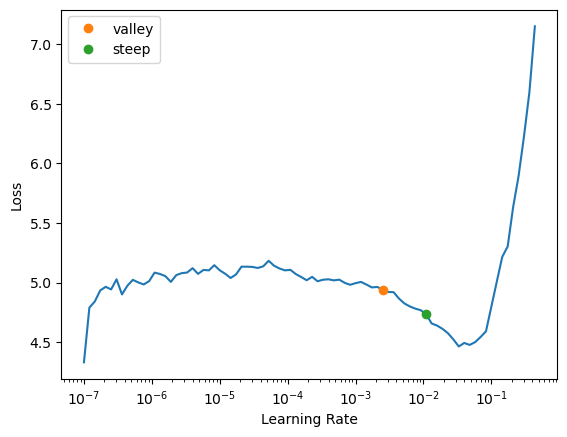

In [ ]:
lr = learn.lr_find(suggest_funcs=(valley, steep))

In [ ]:
base_lr = (lr.valley + lr.steep)/2
base_lr

0.006738334195688367

In [ ]:
learn.fine_tune(8, base_lr=base_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.405715,0.958065,0.702991,04:24
1,1.338703,0.967469,0.709402,04:23
2,1.219364,1.004807,0.732906,04:22
3,1.109134,0.931632,0.745726,04:23
4,0.781717,0.967456,0.709402,04:23
5,0.557352,0.825653,0.762821,04:11
6,0.426474,0.808017,0.750000,04:13
7,0.347061,0.786516,0.767094,04:23


In [ ]:
learn.save(NB_DIR/'..'/'models'/'plantdoc-convnext_small_in22k')

Path('/data-ssd/Dropbox/Jobb/projects/ML/medGPU1-alex/agtech/notebooks/../models/plantdoc-convnext_small_in22k.pth')

### Evaluate on test data

In [ ]:
test_dl = ImageDataLoaders.from_folder(path, train='train', valid='test', bs=16, item_tfms=Resize(800),
                                    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])       
                            

In [ ]:
learn.dls = test_dl

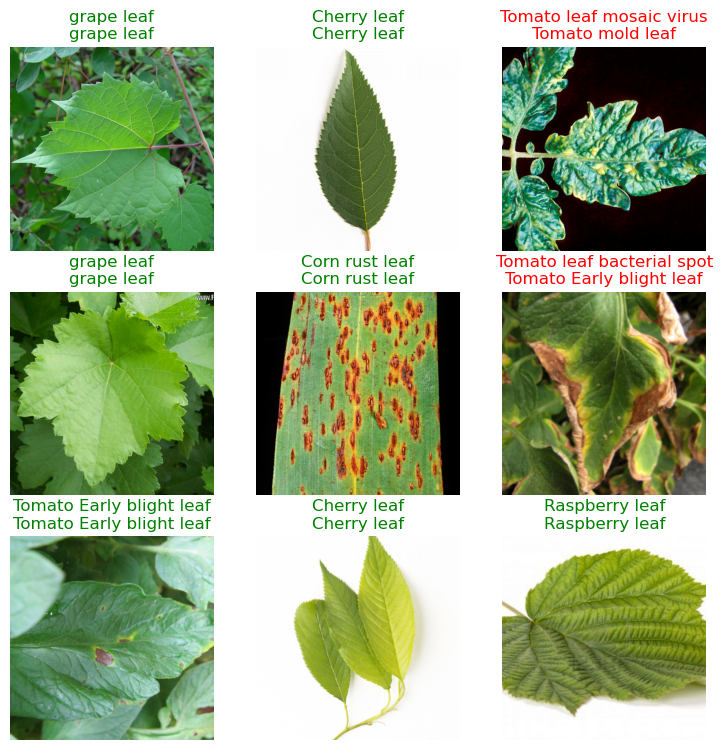

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused()

[('Corn leaf blight', 'Corn Gray leaf spot', 5),
 ('Potato leaf late blight', 'Potato leaf early blight', 5),
 ('Tomato leaf mosaic virus', 'Tomato mold leaf', 4),
 ('Tomato leaf bacterial spot', 'Tomato Septoria leaf spot', 3),
 ('Bell_pepper leaf', 'Bell_pepper leaf spot', 2),
 ('Bell_pepper leaf spot', 'Bell_pepper leaf', 2),
 ('Bell_pepper leaf spot', 'Tomato leaf bacterial spot', 2),
 ('Cherry leaf', 'Apple leaf', 2),
 ('Potato leaf early blight', 'Potato leaf late blight', 2),
 ('Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 2),
 ('Tomato leaf', 'Tomato leaf late blight', 2),
 ('Tomato mold leaf', 'Tomato leaf late blight', 2),
 ('Apple leaf', 'Apple Scab Leaf', 1),
 ('Apple leaf', 'Cherry leaf', 1),
 ('Apple rust leaf', 'Apple Scab Leaf', 1),
 ('Blueberry leaf', 'Apple Scab Leaf', 1),
 ('Blueberry leaf', 'Apple leaf', 1),
 ('Blueberry leaf', 'Tomato leaf bacterial spot', 1),
 ('Cherry leaf', 'Apple Scab Leaf', 1),
 ('Cherry leaf', 'Peach leaf', 1),
 ('Corn Gray leaf 

In [ ]:
preds = learn.get_preds(with_preds=True, with_targs=True)

In [ ]:
accuracy(preds[0], preds[1])

TensorBase(0.7203)

> This can be compared with the dataset creators results from November 2019: https://arxiv.org/pdf/1911.10317.pdf. They report 70.53% accuracy on the test set.